In [1]:
## Standard Imports ##
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')

import numpy as np
import scipy as sp

import time as timeit
import datetime
import sys,os

## Update External Codes ##
import importlib

## Import Handmade Functions ##
sys.path.append(os.path.join(os.path.abspath(''), '00 - GeneralFunctions'))
import inp
import varFam
import stochMod

## Generate Input Excitation
The purpose of this file is to generate and save the input excitation, response measurement data, and measurement/process uncertainty information so that it can be used uniformly across sample cases without the need for regeneration in each file. 

Note that eventually all these files will be merged together into one large example, but for now, it's best for my sanity to keep them separate. 

### Test Information
This file generates a Band-limited white noise excitation, ranging from 0-10 Hz, with a maximum amplitude of 15 m. This sample excitation is then used to simulate the nondimensionalized response of a SDOF Bouc-Wen oscillator. 

### System Parameters

In [2]:
## Parameters and Initial Conditions ##
m = 1.    # kg
c = 0.3   # Ns/m
k = 9.    # N/m
beta = 2  # 1/m^2
gamma = 1 # 1/m^2
n = 2     # dimensionless

xi = c/2/np.sqrt(k*m)   # Damping ratio, non-dimensional
wn = np.sqrt(k/m)       # natural frequency, rad/sec

# Linear System 
icsLinear = [0., 0.]  # Initial Conditions
parLinear = [xi,wn]

# Bouc-Wen System
icsBW = [0., 0., 0.]  # Initial Conditions
parBW = [xi,wn,beta, gamma, n]

# Lay out Noise Percentages #
seeds = [1234,2345]
wNoiseLinear = np.ones(2)*0.02
wNoiseBW = np.ones(3)*0.02
vNoise = 0.2

### System Model and Integration Scheme

In [3]:
def LSDOF(y, par, exc=None):
    """
    This is the state space model for a linear SDOF oscillator.
      
    states = 1x2 vector of states 
    params = 1x2 vector of params (xi,wn)
    exc = base excitation vector
    """
    if exc is None:
        exc = np.zeros(y[0].shape)
            
    x1dot = y[1]
    x2dot = -exc - 2*par[0]*par[1]*y[1] - np.square(par[1])*y[0]

    return np.stack((x1dot, x2dot), axis=0)

def BW(y, par, exc=None):
    """
    This is the state space model for a nondimensionalized SDOF Bouc-Wen System.
      
    states = 1x3 vector of states 
    params = 1x6 vector of params (xi,wn,beta,gamma,n)
    exc = base excitation vector
    """
    if exc is None:
        exc = np.zeros(y[0].shape)
            
    x1dot = y[1]
    x2dot = -exc - 2*par[0]*par[1]*y[1] - np.square(par[1])*y[2]
    x3dot = (y[1] - par[2]*np.absolute(y[1])*np.power(np.absolute(y[2]), par[4]-1)*y[2] 
        - par[3]*y[1]*np.power(np.absolute(y[2]), par[4]))

    return np.stack((x1dot, x2dot, x3dot), axis=0)

def BW_smooth(y, par, exc=None):
    """
    This is the state space model for a nondimensionalized SDOF Bouc-Wen System.
      
    states = 1x3 vector of states 
    params = 1x6 vector of params (c,k,beta,gamma,n,m)
    exc = base excitation vector
    """
    if exc is None:
        exc = np.zeros(y[0].shape)
        
    rho = 20
            
    x1dot = y[1]
    x2dot = -exc - 2*par[0]*par[1]*y[1] - np.square(par[1])*y[2]
    x3dot = (y[1] - par[2]*y[1]*np.power(np.tanh(rho*y[2])*y[2], par[4])*np.tanh(rho*y[1]*y[2]) 
        - par[3]*y[1]*np.power(np.tanh(rho*y[2])*y[2], par[4]))

    return np.stack((x1dot, x2dot, x3dot), axis=0)

def Euler(fun, dt, y, par, inp):
    return y + dt*fun(y,par,exc=inp)

### Generate BLWN Signal

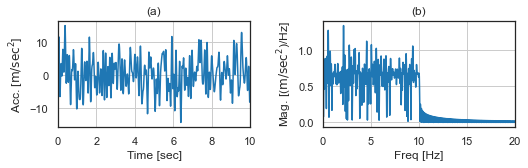

In [4]:
fs = 256. # Hz
dt = 1/fs  # sec
Tmax = 10. # sec
Fmax = 10  # Hz
amp = 15.0  # m

np.random.seed(234)
(time, inpDisp, inpAcc) = inp.BLWN_improved(Tmax, Fmax, amp, fs, plot=False)

## Plot Response ##
fig, ax = plt.subplots(1,2, figsize = (7.5, 2.5))
ax[0].plot(time, inpAcc)
ax[0].set_xlabel('Time [sec]')
ax[0].set_ylabel(r'Acc. [$\mathrm{m/sec}^2$]')
#ax[0].set_title('Base Acceleration Input to Batch VI - ' + str(int(fs*10)) + ' samples')
ax[0].set_title('(a)')
ax[0].set_xlim((0, Tmax))
ax[0].grid()

## Take FFT of the Observations ##
NFFT = int(2**(np.ceil(np.log2(np.abs(len(inpAcc))))+4))
yInp = np.fft.fft(inpAcc, n=NFFT)/len(inpAcc)
freq = fs*np.linspace(0,1,int(NFFT))

ax[1].plot(freq[0:int(NFFT/2)], 2*np.abs(yInp[0:int(NFFT/2)]), label="Amplitude Density Spectrum on Inp")
ax[1].set_xlabel('Freq [Hz]')
ax[1].set_ylabel(r'Mag. [($\mathrm{m/sec}^2$)/Hz]')
#ax[1].set_title('Single-Sided Amplitude Density Spectrum')
ax[1].set_title('(b)')
ax[1].set_xlim((0, 20))#int(NFFT/2)))
ax[1].grid(1)

plt.tight_layout()
plt.savefig('Input.tiff', dpi=600)


### System Response
#### Linear

In [5]:
############### Build Model Response ###################
statesLinear = np.zeros((len(icsLinear),len(time)))
statesLinear[:,0] = icsLinear

for tt in range(1,len(time)):
    statesLinear[:,tt] = Euler(LSDOF, dt, statesLinear[:,tt-1], 
                               parLinear, inpAcc[tt-1])

accLinear = LSDOF(statesLinear, parLinear)[1]

############### Build True Response ###################
# Build Additive Noise Signals #
rmsStates = np.sqrt(np.mean(np.square(statesLinear), axis=1))
rmsMeas = np.sqrt(np.mean(np.square(accLinear)))

stdW = np.sqrt(dt)*rmsStates*wNoiseLinear #
stdV = rmsMeas*vNoise

np.random.seed(seeds[0])
wLinear = stdW.reshape(-1,1)*np.random.multivariate_normal(np.zeros(2), np.eye(2), len(time)).transpose()

np.random.seed(seeds[1])
vLinear = stdV*np.random.normal(loc=0., scale = 1., size = len(time))

# Simulate Response #
statesLinearPNoise = np.zeros((len(icsLinear),len(time)))
statesLinearPNoise[:,0] = icsLinear

for tt in range(1,len(time)):
    statesLinearPNoise[:,tt] = Euler(LSDOF, dt, statesLinearPNoise[:,tt-1],
                                     parLinear, inpAcc[tt-1]) + wLinear[:,tt-1]

accLinearPMNoise = LSDOF(statesLinearPNoise, parLinear)[1] + vLinear

############### Lay Out Specific Uncertainty Parameters ###################
QfactorLinear = stdW
RfactorLinear = stdV

print('The standard deviation of the process noise, save for the integration factor, is ' + str(QfactorLinear))
print('The standard deviation of the measurement noise is ' + str(RfactorLinear))

The standard deviation of the process noise, save for the integration factor, is [0.00044825 0.00138628]
The standard deviation of the measurement noise is 0.655181715322521


#### Bouc-Wen Model

In [6]:
############### Build Model Response ###################
statesBW = np.zeros((len(icsBW),len(time)))
statesBW[:,0] = icsBW

for tt in range(1,len(time)):
    statesBW[:,tt] = Euler(BW, dt, statesBW[:,tt-1], parBW, inpAcc[tt-1])

accBW = BW(statesBW, parBW)[1]

############### Build Model Response - Smooth ###################
states_smoothBW = np.zeros((len(icsBW),len(time)))
states_smoothBW[:,0] = icsBW

for tt in range(1,len(time)):
    states_smoothBW[:,tt] = Euler(BW_smooth, dt, states_smoothBW[:,tt-1], 
                                parBW, inpAcc[tt-1])

acc_smoothBW = BW_smooth(states_smoothBW, parBW)[1]

############### Build True Response ###################
# Build Additive Noise Signals #
rmsStates = np.sqrt(np.mean(np.square(statesBW), axis=1))
rmsMeas = np.sqrt(np.mean(np.square(accBW)))

stdW = np.sqrt(dt)*rmsStates*wNoiseBW #
stdV = rmsMeas*vNoise

np.random.seed(seeds[0])
wBW = stdW.reshape(-1,1)*np.random.multivariate_normal(np.zeros(3), np.eye(3), len(time)).transpose()

np.random.seed(seeds[1])
vBW = stdV*np.random.normal(loc=0., scale = 1., size = len(time))

# Simulate Response #
statesPNoiseBW = np.zeros((len(icsBW),len(time)))
statesPNoiseBW[:,0] = icsBW

for tt in range(1,len(time)):
    statesPNoiseBW[:,tt] = Euler(BW, dt, statesPNoiseBW[:,tt-1], 
                               parBW, inpAcc[tt-1]) + wBW[:,tt-1]

accPMNoiseBW = BW(statesPNoiseBW, parBW)[1] + vBW

############### Lay Out Specific Uncertainty Parameters ###################
QfactorBW = stdW
RfactorBW = stdV

print('The standard deviation of the process noise, save for the integration factor, is ' + str(QfactorBW))
print('The standard deviation of the measurement noise is ' + str(RfactorBW))

The standard deviation of the process noise, save for the integration factor, is [0.00044203 0.00111409 0.00032154]
The standard deviation of the measurement noise is 0.4784778514584699


0.4179751277943084
0.5586022735942626


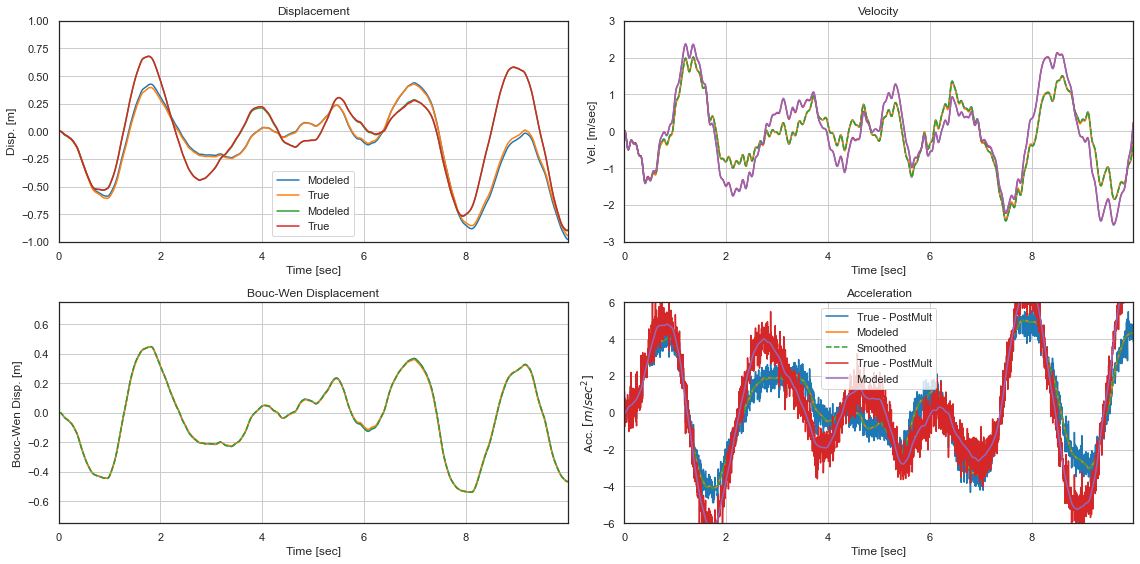

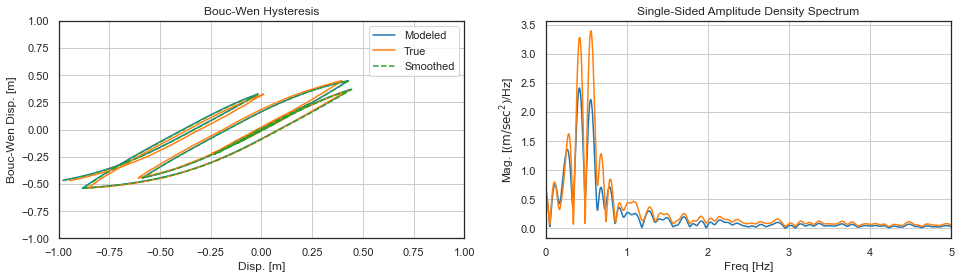

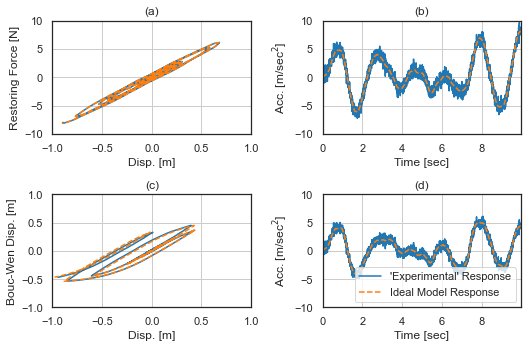

In [7]:
############### Plot Response ###################
fig, ax = plt.subplots(2,2, figsize = (16, 8))
ax[0,0].plot(time,statesBW[0,:], label="Modeled")
ax[0,0].plot(time,statesPNoiseBW[0,:], label="True")
ax[0,0].plot(time,statesLinear[0,:], label="Modeled")
ax[0,0].plot(time,statesLinearPNoise[0,:], label="True")
ax[0,0].set_xlabel('Time [sec]')
ax[0,0].set_ylabel('Disp. [m]')
ax[0,0].set_title('Displacement')
ax[0,0].set_xlim((0, time[-1]))
ax[0,0].set_ylim((-1, 1))
ax[0,0].grid(1)
ax[0,0].legend()

ax[0,1].plot(time,statesBW[1,:], label="Modeled")
ax[0,1].plot(time,statesPNoiseBW[1,:], label="True")
ax[0,1].plot(time,states_smoothBW[1,:], '--', label="Smoothed")
ax[0,1].plot(time,statesLinear[1,:], label="Modeled")
ax[0,1].plot(time,statesLinearPNoise[1,:], label="True")
ax[0,1].set_xlabel('Time [sec]')
ax[0,1].set_ylabel('Vel. [m/sec]')
ax[0,1].set_title('Velocity')
ax[0,1].set_xlim((0, time[-1]))
ax[0,1].set_ylim((-3, 3))
ax[0,1].grid(1)

ax[1,0].plot(time,statesBW[2,:], label="Modeled")
ax[1,0].plot(time,statesPNoiseBW[2,:], label="True")
ax[1,0].plot(time,states_smoothBW[2,:], '--', label="Smoothed")
ax[1,0].set_xlabel('Time [sec]')
ax[1,0].set_ylabel('Bouc-Wen Disp. [m]')
ax[1,0].set_title('Bouc-Wen Displacement')
ax[1,0].set_xlim((0, time[-1]))
ax[1,0].set_ylim((-0.75, 0.75))
ax[1,0].grid(1)

ax[1,1].plot(time,accPMNoiseBW, label="True - PostMult")
ax[1,1].plot(time,accBW, label="Modeled")
ax[1,1].plot(time,acc_smoothBW, '--', label="Smoothed")
ax[1,1].plot(time,accLinearPMNoise, label="True - PostMult")
ax[1,1].plot(time,accLinear, label="Modeled")
ax[1,1].set_xlabel('Time [sec]')
ax[1,1].set_ylabel(r'Acc. $[m/sec^2]$')
ax[1,1].set_title('Acceleration')
ax[1,1].set_xlim((0, time[-1]))
ax[1,1].set_ylim((-6, 6))
ax[1,1].grid(1)
ax[1,1].legend()

plt.tight_layout()

fig, ax = plt.subplots(1,2, figsize = (16, 4))
ax[0].plot(statesBW[0,:],statesBW[2,:], label="Modeled")
ax[0].plot(statesPNoiseBW[0,:],statesPNoiseBW[2,:], label="True")
ax[0].plot(states_smoothBW[0,:],states_smoothBW[2,:], '--', label="Smoothed")
ax[0].set_xlabel('Disp. [m]')
ax[0].set_ylabel('Bouc-Wen Disp. [m]')
ax[0].set_title('Bouc-Wen Hysteresis')
ax[0].set_xlim((-1, 1))
ax[0].set_ylim((-1, 1))
ax[0].grid(1)
ax[0].legend()

## Take FFT of the Observations ##
NFFT = int(2**(np.ceil(np.log2(np.abs(len(accPMNoiseBW))))+4))
yInp = np.fft.fft(accPMNoiseBW, n=NFFT)/len(accPMNoiseBW)
freq = fs*np.linspace(0,1,int(NFFT))


ax[1].plot(freq[0:int(NFFT/2)], 2*np.abs(yInp[0:int(NFFT/2)]), label="Amplitude Density Spectrum on Resp")
ax[1].set_xlabel('Freq [Hz]')
ax[1].set_ylabel(r'Mag. [($\mathrm{m/sec}^2$)/Hz]')
ax[1].set_title('Single-Sided Amplitude Density Spectrum')
ax[1].set_xlim((0, 5))#int(NFFT/2)))
ax[1].grid(1)

print(freq[np.argmax(2*np.abs(yInp[0:int(NFFT/2)]))])

NFFT = int(2**(np.ceil(np.log2(np.abs(len(accLinearPMNoise))))+4))
yInp = np.fft.fft(accLinearPMNoise, n=NFFT)/len(accLinearPMNoise)
freq = fs*np.linspace(0,1,int(NFFT))


ax[1].plot(freq[0:int(NFFT/2)], 2*np.abs(yInp[0:int(NFFT/2)]), label="Amplitude Density Spectrum on Resp")
ax[1].set_xlabel('Freq [Hz]')
ax[1].set_ylabel(r'Mag. [($\mathrm{m/sec}^2$)/Hz]')
ax[1].set_title('Single-Sided Amplitude Density Spectrum')
ax[1].set_xlim((0, 5))#int(NFFT/2)))
ax[1].grid(1)

print(freq[np.argmax(2*np.abs(yInp[0:int(NFFT/2)]))])

### Figure for the Paper ###
fig, ax = plt.subplots(2,2, figsize = (7.5, 5))
ax[1,0].plot(statesPNoiseBW[0,:],statesPNoiseBW[2,:],  color = 'C0', label="'Experimental' Response")
ax[1,0].plot(statesBW[0,:],statesBW[2,:], '--', color = 'C1', label="Ideal Model Response")
ax[1,0].set_xlabel('Disp. [m]')
ax[1,0].set_ylabel('Bouc-Wen Disp. [m]')
ax[1,0].set_title('(c)')
ax[1,0].set_xlim((-1, 1))
ax[1,0].set_ylim((-1, 1))
ax[1,0].grid(1)
#ax[0,0].legend(loc ='lower right')

ax[1,1].plot(time,accPMNoiseBW, label="'Experimental' Response")
ax[1,1].plot(time,accPMNoiseBW - vBW, '--', label="Ideal Model Response")
ax[1,1].set_xlabel('Time [sec]')
ax[1,1].set_ylabel(r'Acc. [m/sec$^2$]')
ax[1,1].set_title('(d)')
ax[1,1].set_xlim((0, time[-1]))
ax[1,1].set_ylim((-10, 10))
ax[1,1].grid(1)
ax[1,1].legend(loc ='lower right')

ax[0,0].plot(statesLinearPNoise[0,:],-m*(accLinearPMNoise - vLinear), color = 'C0', label="'Experimental' Response")
ax[0,0].plot(statesLinear[0,:],-m*(-2*xi*wn*statesLinear[1] - np.square(wn)*statesLinear[0]),  '--',color = 'C1', label="Ideal Model Response")
ax[0,0].set_xlabel('Disp. [m]')
ax[0,0].set_ylabel('Restoring Force [N]')
ax[0,0].set_title('(a)')
ax[0,0].set_xlim((-1, 1))
ax[0,0].set_ylim((-10, 10))
ax[0,0].grid(1)
#ax[1,0].legend(loc ='lower right')

ax[0,1].plot(time,accLinearPMNoise,  label="'Experimental' Response")
ax[0,1].plot(time,(accLinearPMNoise - vLinear), '--', label="Ideal Model Response")
ax[0,1].set_xlabel('Time [sec]')
ax[0,1].set_ylabel(r'Acc. [m/sec$^2$]')
ax[0,1].set_title('(b)')
ax[0,1].set_xlim((0, time[-1]))
ax[0,1].set_ylim((-10, 10))
ax[0,1].grid(1)
#ax[0,1].legend(loc ='lower right')

plt.tight_layout()
plt.savefig('Response.tiff', dpi=600)

## Generate Data for Secondary Event
This ground input will be used to help test the predictive capacity of the resulting identified inference models. 

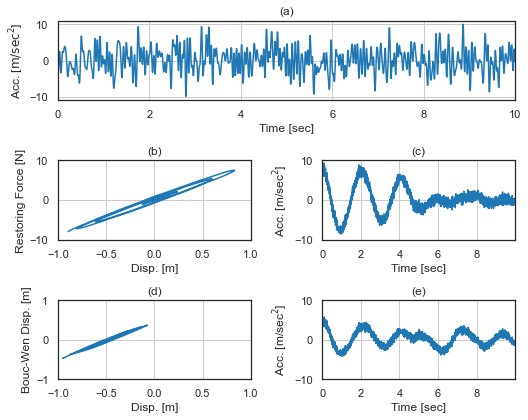

In [14]:
## BLWN INPUT ##
fs = 256. # Hz
dt = 1/fs  # sec
Tmax = 10. # sec
Fmax_pred = 20.  # Hz   SLIGHT Increase IN FREQUENCY BAND
amp_pred = 10.  # m  LARGE Reduction IN AMPLITUDE

np.random.seed(2165)
(time, predDisp, predBase) = inp.BLWN_improved(Tmax, Fmax_pred, amp_pred, fs, plot=False)

############### Build Linear Response ###################
seeds = [4432,6654]

np.random.seed(seeds[0])
wPred = QfactorLinear.reshape(-1,1)*np.random.multivariate_normal(np.zeros(2), np.eye(2), len(time)).transpose()

np.random.seed(seeds[1])
vPredLinear = RfactorLinear*np.random.normal(loc=0., scale = 1., size = len(time))

# Simulate Response #
predStatesPNoiseLinear = np.zeros((len(icsLinear),len(time)))
predStatesPNoiseLinear[:,0] = statesLinearPNoise[:,-1]

for tt in range(1,len(time)):
    predStatesPNoiseLinear[:,tt] = Euler(LSDOF, dt, predStatesPNoiseLinear[:,tt-1], 
                                         parLinear, predBase[tt-1]) + wPred[:,tt-1]

predAccPMNoiseLinear = LSDOF(predStatesPNoiseLinear, parLinear)[1] + vPredLinear

############### Build Nonlinear Response ###################
seeds = [4432,6654]

np.random.seed(seeds[0])
wPred = QfactorBW.reshape(-1,1)*np.random.multivariate_normal(np.zeros(3), np.eye(3), len(time)).transpose()

np.random.seed(seeds[1])
vPredBW = RfactorBW*np.random.normal(loc=0., scale = 1., size = len(time))

# Simulate Response #
predStatesPNoiseBW = np.zeros((len(icsBW),len(time)))
predStatesPNoiseBW[:,0] = statesPNoiseBW[:,-1]

for tt in range(1,len(time)):
    predStatesPNoiseBW[:,tt] = Euler(BW, dt, predStatesPNoiseBW[:,tt-1], 
                                     parBW, predBase[tt-1]) + wPred[:,tt-1]

predAccPMNoiseBW = BW(predStatesPNoiseBW, parBW)[1] + vPredBW

############### Plot Response ###################
fig = plt.figure(figsize = (7.5, 6))
ax1 = fig.add_subplot(3,1,1)
ax1.plot(time, predBase)
ax1.set_xlabel('Time [sec]')
ax1.set_ylabel(r'Acc. [$\mathrm{m/sec}^2$]')
ax1.set_title('(a)')
ax1.set_xlim((0, Tmax))
ax1.grid()

ax2 = fig.add_subplot(3,2,5)
ax2.plot(predStatesPNoiseBW[0,:],predStatesPNoiseBW[2,:],  color = 'C0', label="'Experimental' Response")
ax2.set_xlabel('Disp. [m]')
ax2.set_ylabel('Bouc-Wen Disp. [m]')
ax2.set_title('(d)')
ax2.set_xlim((-1, 1))
ax2.set_ylim((-1, 1))
ax2.grid(1)
#ax2.legend(loc ='lower right')

ax3 = fig.add_subplot(3,2,6)
ax3.plot(time,predAccPMNoiseBW, label="'Experimental' Response")
#ax3.plot(time,predAccPMNoiseBW - vPredBW, '--', label="Ideal Model Response")
ax3.set_xlabel('Time [sec]')
ax3.set_ylabel(r'Acc. [m/sec$^2$]')
ax3.set_title('(e)')
ax3.set_xlim((0, time[-1]))
ax3.set_ylim((-10, 10))
ax3.grid(1)
#ax3.legend(loc ='lower right')

ax4 = fig.add_subplot(3,2,3)
ax4.plot(predStatesPNoiseLinear[0,:],-m*(predAccPMNoiseLinear - vPredLinear), color = 'C0', label="'Experimental' Response")
ax4.set_xlabel('Disp. [m]')
ax4.set_ylabel('Restoring Force [N]')
ax4.set_title('(b)')
ax4.set_xlim((-1, 1))
ax4.set_ylim((-10, 10))
ax4.grid(1)
#ax4.legend(loc ='lower right')

ax5 = fig.add_subplot(3,2,4)
ax5.plot(time,predAccPMNoiseLinear,  label="'Experimental' Response")
#ax5.plot(time,(predAccPMNoiseLinear - vPredLinear), '--', label="Ideal Model Response")
ax5.set_xlabel('Time [sec]')
ax5.set_ylabel(r'Acc. [m/sec$^2$]')
ax5.set_title('(c)')
ax5.set_xlim((0, time[-1]))
ax5.set_ylim((-10, 10))
ax5.grid(1)
#ax5.legend(loc ='lower right')

plt.tight_layout()
plt.savefig('PredResponse.tiff', dpi=600)

### Simulate True System Response to Predictive Input

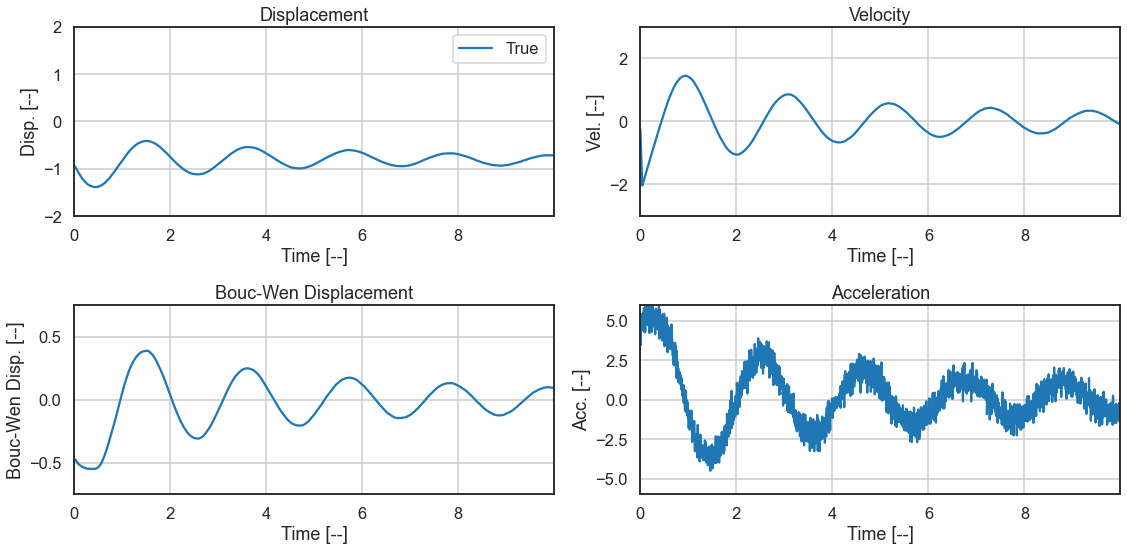

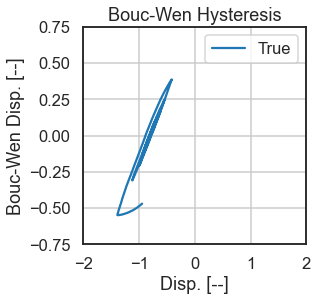

In [39]:
############### Build True Response ###################
seeds = [4432,6654]

np.random.seed(seeds[0])
wPred = stdW.reshape(-1,1)*np.random.multivariate_normal(np.zeros(3), np.eye(3), len(time)).transpose()

np.random.seed(seeds[1])
vPred = stdV*np.random.normal(loc=0., scale = 1., size = len(time))

# Simulate Response #
predStatesPNoise = np.zeros((len(ics),len(time)))
predStatesPNoise[:,0] = statesPNoise[:,-1]

for tt in range(1,len(time)):
    predStatesPNoise[:,tt] = Euler(BW, dt, predStatesPNoise[:,tt-1], par, predBase[tt-1]) + wPred[:,tt-1]

predAccPMNoise = BW(predStatesPNoise, par)[1] + vPred

############### Plot Response ###################
fig, ax = plt.subplots(2,2, figsize = (16, 8))
ax[0,0].plot(time,predStatesPNoise[0,:], label="True")
ax[0,0].set_xlabel('Time [--]')
ax[0,0].set_ylabel('Disp. [--]')
ax[0,0].set_title('Displacement')
ax[0,0].set_xlim((0, time[-1]))
ax[0,0].set_ylim((-2,2))
ax[0,0].grid(1)
ax[0,0].legend()

ax[0,1].plot(time,predStatesPNoise[1,:], label="True")
ax[0,1].set_xlabel('Time [--]')
ax[0,1].set_ylabel('Vel. [--]')
ax[0,1].set_title('Velocity')
ax[0,1].set_xlim((0, time[-1]))
ax[0,1].set_ylim((-3,3))
ax[0,1].grid(1)

ax[1,0].plot(time,predStatesPNoise[2,:], label="True")
ax[1,0].set_xlabel('Time [--]')
ax[1,0].set_ylabel('Bouc-Wen Disp. [--]')
ax[1,0].set_title('Bouc-Wen Displacement')
ax[1,0].set_xlim((0, time[-1]))
ax[1,0].set_ylim((-0.75,0.75))
ax[1,0].grid(1)

ax[1,1].plot(time,predAccPMNoise, label="True")
ax[1,1].set_xlabel('Time [--]')
ax[1,1].set_ylabel('Acc. [--]')
ax[1,1].set_title('Acceleration')
ax[1,1].set_xlim((0, time[-1]))
ax[1,1].set_ylim((-6,6))
ax[1,1].grid(1)

plt.tight_layout()

fig, ax = plt.subplots(figsize = (4,4))
ax.plot(predStatesPNoise[0,:],predStatesPNoise[2,:], label="True")
ax.set_xlabel('Disp. [--]')
ax.set_ylabel('Bouc-Wen Disp. [--]')
ax.set_title('Bouc-Wen Hysteresis')
ax.set_xlim((-2,2))
ax.set_ylim((-0.75,0.75))
ax.grid(1)
ax.legend()

In [40]:
np.savez('predInp_Impulse', dt= dt, time = time, predInp = predBase, predStatesPNoise=predStatesPNoise, 
         predAccPMNoise=predAccPMNoise,Qfactor=stdW,Rfactor=stdV, m = m)